This file will take the deltaX, deltaY (with these two possibly combined into deltaR), deltaE, and KS p-value and use them to form a model

In [1]:
from evwTools import *

Welcome to JupyROOT 6.12/06


In [2]:
# Load libraries
import sklearn
import pandas
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates
from pandas.plotting import radviz
import seaborn as sns
import numpy as np

In [3]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")
tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

In [4]:
#tcomp.Print()

In [5]:
f = uproot.open("./data/gm2offline_ana.root")
t = f['farline/evwTree']

In [6]:
df = t.pandas.df(['deltaX','deltaY','deltaE', 'energyWest', 'deltaT', 'timeCorr'])

In [7]:
df.head()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr
0,0.070596,0.061639,-756.748057,2449.362257,-2.261171,-2.184671
1,-0.102030,-0.114186,-112.097231,431.534894,-2.250340,-2.184671
2,0.060243,-0.024693,-525.883136,1752.701592,-2.237720,-2.184671
3,0.557247,0.055393,-379.274712,1484.290831,-2.173777,-2.184671
4,-0.038519,0.013205,-433.965135,1952.831953,-2.133583,-2.184671


In [12]:
dfbad = df.loc[df['deltaX'] > 3]
dfgood = df.loc[df['deltaX'] < 0.2].loc[df['deltaY'] < 0.2].loc[df['deltaE'] < 500].loc[df['energyWest'] > 2500]

In [27]:
dfbad['class'] = pandas.Series(0, index=dfbad.index)
dfgood['class'] = pandas.Series(1, index=dfgood.index)

/home/jlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
dfbad.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,26.000000,2.600000e+01,26.000000,26.000000,26.000000,26.000000,26.0
mean,3.562673,-1.446329e-01,-122.083058,285.597684,-0.739910,-0.830763,0.0
std,0.519544,6.638877e-01,52.465268,131.473593,0.967673,0.999074,0.0
min,3.023543,-1.321471e+00,-267.503709,134.965751,-2.492966,-2.533535,0.0
25%,3.223635,-6.588288e-01,-150.867275,215.951149,-1.012098,-0.955222,0.0
50%,3.409724,2.220446e-16,-121.703286,238.066398,-0.624658,-0.678097,0.0
75%,3.758287,2.847616e-01,-92.936096,290.841549,-0.114041,-0.100543,0.0
max,4.859385,1.036124e+00,4.915337,746.600459,1.334074,0.543326,0.0


In [15]:
dfgood.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.0
mean,-0.013391,0.000624,-1025.150415,2673.701812,-0.782365,-0.765088,1.0
std,0.059875,0.050760,260.676221,148.366222,0.816621,0.815580,0.0
min,-0.459936,-0.167874,-1756.210900,2500.082548,-2.799824,-2.533535,1.0
25%,-0.044779,-0.028313,-1192.369057,2564.007517,-0.965731,-0.955265,1.0
50%,-0.010540,0.000000,-1021.922460,2641.175353,-0.695740,-0.678097,1.0
75%,0.023182,0.032433,-882.893801,2749.769372,-0.172955,-0.184445,1.0
max,0.193040,0.180785,318.957009,4579.775974,0.596063,0.543326,1.0


In [16]:
dfmachinelearning = pandas.concat([dfbad,dfgood])

In [17]:
dfmachinelearning.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.035934,-0.001380,-1012.694314,2640.762445,-0.781779,-0.765994,0.986207
std,0.425636,0.093149,279.553721,315.526445,0.818606,0.818104,0.116662
min,-0.459936,-1.321471,-1756.210900,134.965751,-2.799824,-2.533535,0.000000
25%,-0.044190,-0.028541,-1190.791301,2560.769936,-0.966080,-0.955265,1.000000
50%,-0.010040,0.000000,-1018.332305,2638.854422,-0.693811,-0.678097,1.000000
75%,0.024924,0.032884,-878.929562,2747.154050,-0.171626,-0.184445,1.000000
max,4.859385,1.036124,318.957009,4579.775974,1.334074,0.543326,1.000000


Now that we have the dataset assembled, lets jump into the machine learning

In [18]:
# Load dataset
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
#names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
path = "/home/jlab/github/leptoquark/data/JetSummary_Combined_1000_10_50.csv"
names = ['n_Total', 'n_Above_0p001', 'n_Above_0p01', 'n_Above_0p1', 'n_Above_1', 'n_Above_10', 'eta_avg', 'eta_std', 'phi_avg', 'phi_std', 'Delta_eta_avg', 'Delta_eta_std', 'Delta_phi_avg', 'Delta_phi_std', 'Delta_eta_avg_w', 'Delta_eta_std_w', 'Delta_phi_avg_w', 'Delta_phi_std_w', 'towerenergy_sum', 'jet_mass','class']
#names = ['n_Total', 'n_Above_1', 'n_Above_10', 'Delta_eta_avg_w', 'Delta_eta_std_w', 'Delta_phi_avg_w', 'Delta_phi_std_w', 'towerenergy_sum','jet_mass','class']
#dataset = pandas.read_csv(path, names=names)

dataset = dfmachinelearning

print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [19]:
# shape
print((dataset.shape)[0])

1885


In [20]:
# head
dataset.head()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
1031,3.312161,0.414020,4.915337,285.051650,-0.614705,-0.678097,0
5992,3.474787,-1.090777,-143.514604,268.943242,-0.038698,-0.002024,0
7031,3.127353,-0.050113,-117.404775,344.269019,0.541724,0.543326,0
7044,3.599963,0.182420,-174.283198,257.310983,1.334074,0.543326,0
9081,3.438912,0.000000,-125.067331,214.794756,-0.019710,-0.017225,0


In [21]:
dataset.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.035934,-0.001380,-1012.694314,2640.762445,-0.781779,-0.765994,0.986207
std,0.425636,0.093149,279.553721,315.526445,0.818606,0.818104,0.116662
min,-0.459936,-1.321471,-1756.210900,134.965751,-2.799824,-2.533535,0.000000
25%,-0.044190,-0.028541,-1190.791301,2560.769936,-0.966080,-0.955265,1.000000
50%,-0.010040,0.000000,-1018.332305,2638.854422,-0.693811,-0.678097,1.000000
75%,0.024924,0.032884,-878.929562,2747.154050,-0.171626,-0.184445,1.000000
max,4.859385,1.036124,318.957009,4579.775974,1.334074,0.543326,1.000000


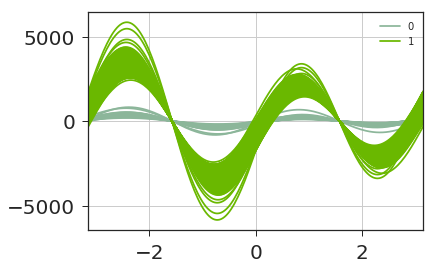

In [22]:
# descriptions and visualizations
andrews_curves(dataset, 'class')
plt.show()

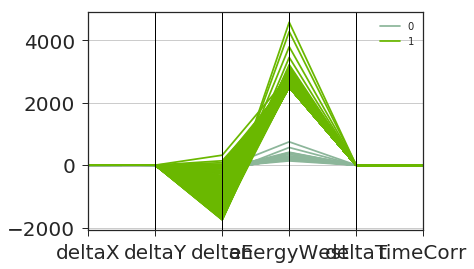

In [23]:
parallel_coordinates(dataset, 'class')
plt.show()

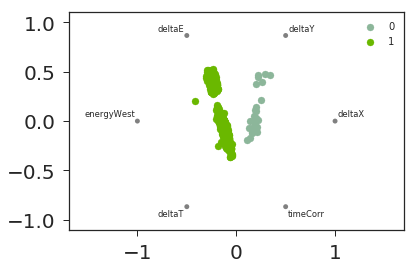

In [24]:
radviz(dataset, 'class')
plt.show()

In [29]:
# class distribution
print(dataset.groupby('class').size())

class
0      26
1    1859
dtype: int64


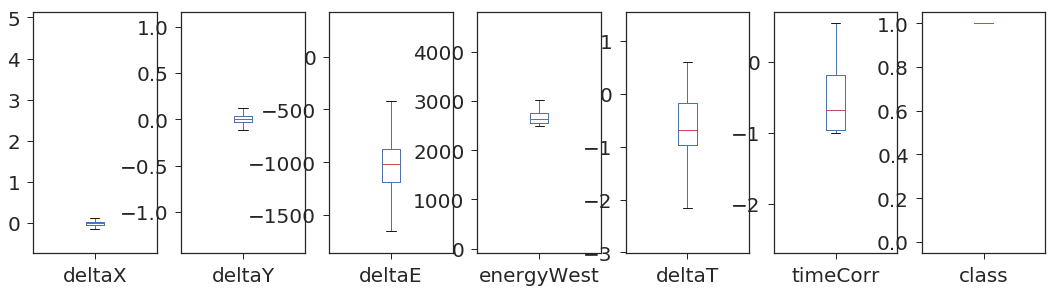

In [38]:
# box and whisker plots
#fix, ax = plt.subplots(figsize=(25,4))
dataset.plot(kind='box', subplots=True, layout=(19,19), figsize=(50,100), sharex=False, sharey=False)
dataset.boxplot()
plt.show()

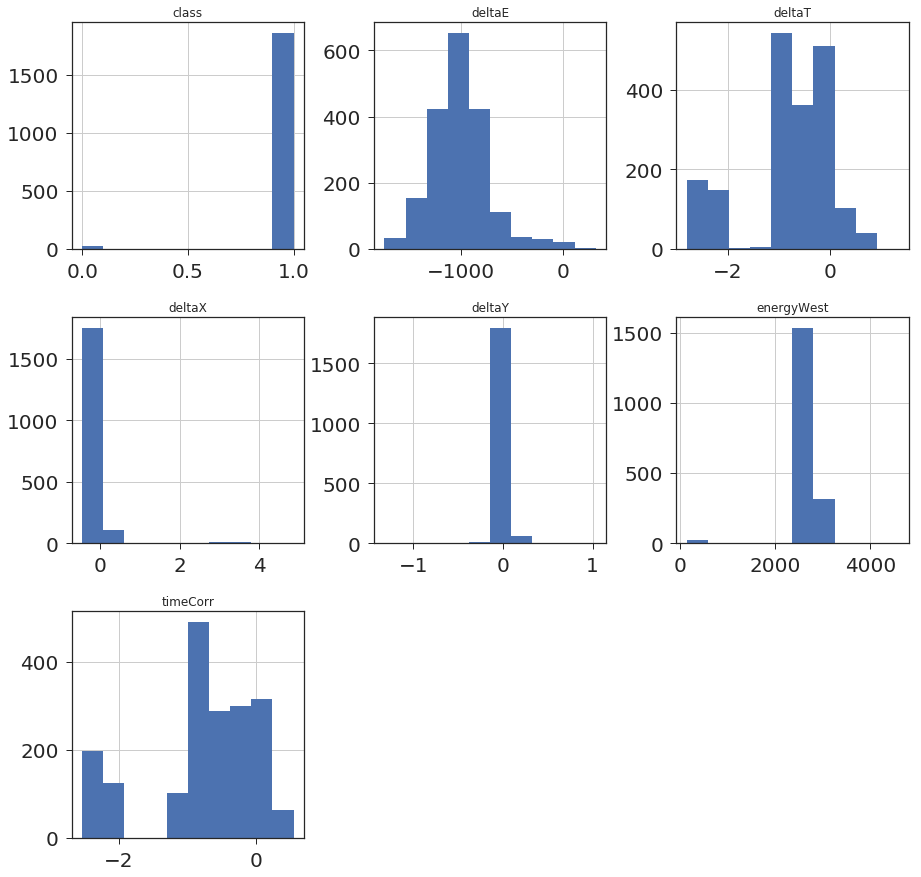

In [39]:
# histograms
dataset.hist(figsize=(15,15))
plt.show()

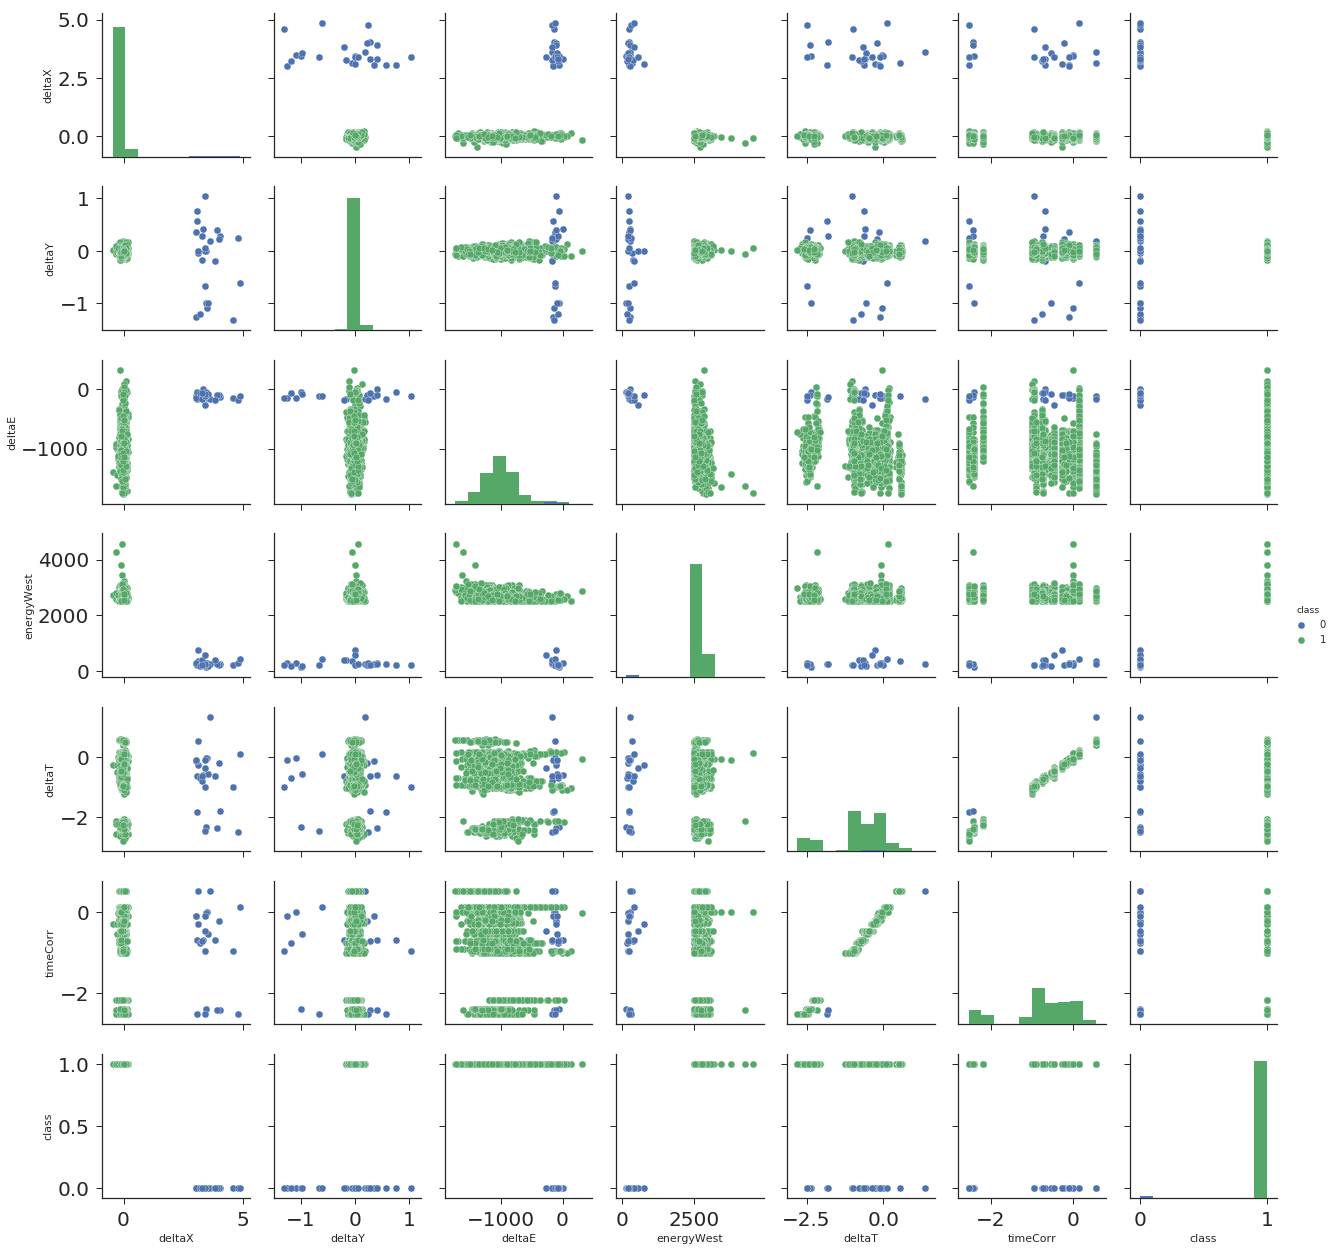

In [40]:
# scatter plot matrix
sns.pairplot(dataset, hue="class")
#plt.savefig("./ding.pdf")
#plt.savefig("./ding.png")
plt.show()

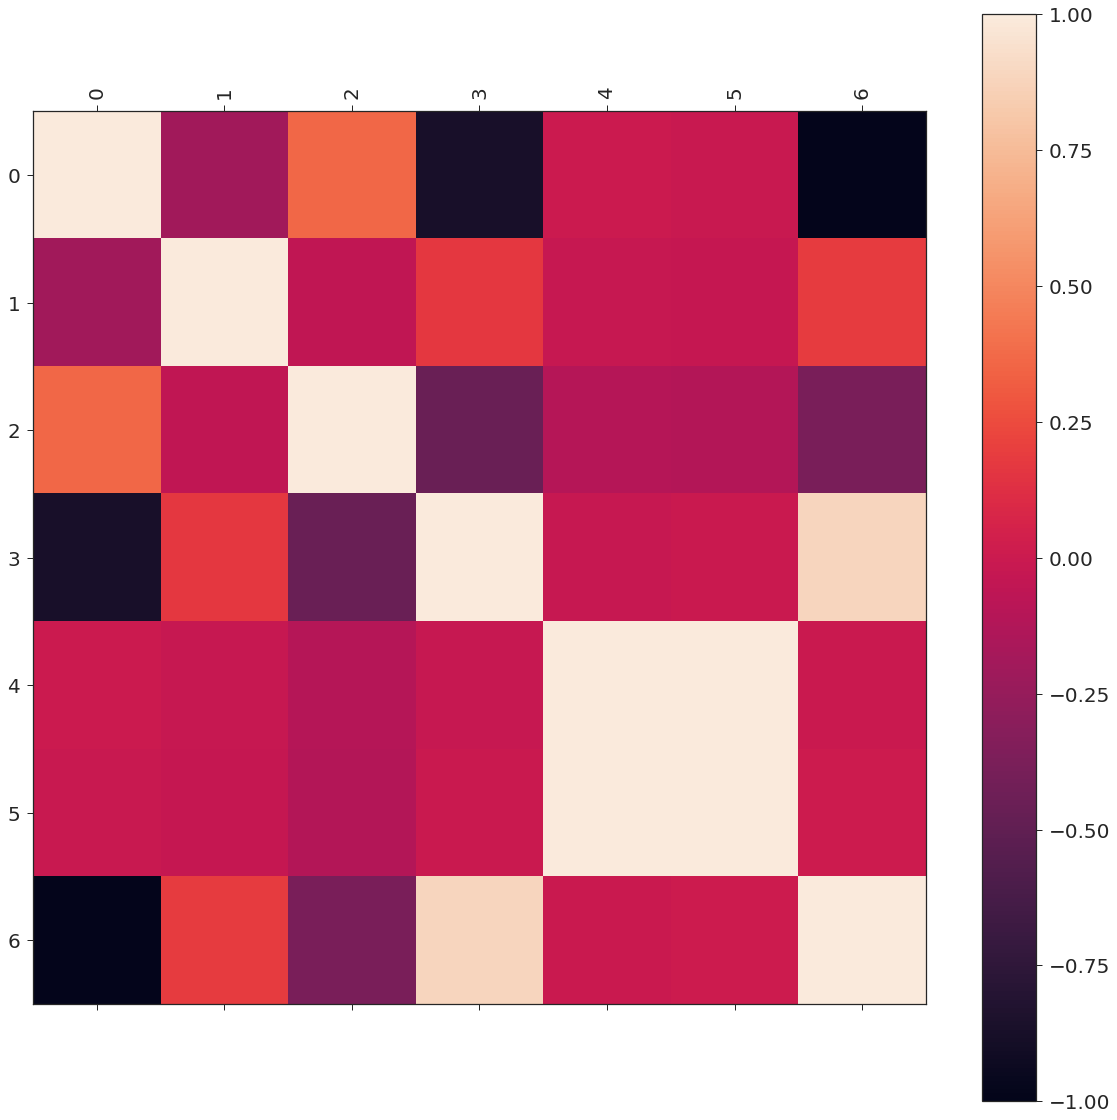

In [51]:
#correllation plot
correlations = dataset.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
#ticks = np.arange(0,20,1)
#ax.set_xticks(ticks)
#ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
plt.xticks(rotation=90)
plt.show()

In [54]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:6]
Y = array[:,6]
print(Y)
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

ding = np.column_stack((X_train,Y_train))
print(ding)
dong = np.column_stack((X_validation,Y_validation))

#np.savetxt("./data/JetSummary_1000_training.csv", ding, delimiter=", ")
#np.savetxt("./data/JetSummary_1000_validation.csv", dong, fmt='%i, %i, %i, %i, %i, %i, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %s')
#np.savetxt("./data/JetSummary_1000_training.csv", ding, fmt='%i, %i, %i, %i, %i, %i, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %s')



[0. 0. 0. ... 1. 1. 1.]
[[ 4.84378239e-02  2.61067908e-02 -8.23720659e+02 ... -2.09356813e-01
  -1.84444884e-01  1.00000000e+00]
 [-1.83077866e-02  1.56685211e-02 -9.78602438e+02 ... -2.26017804e+00
  -2.18467084e+00  1.00000000e+00]
 [-2.29139217e-02  9.93910968e-02 -7.68095314e+02 ... -6.23901775e-02
  -1.72245611e-02  1.00000000e+00]
 ...
 [ 2.30728715e-02 -1.45992215e-02 -1.34210258e+03 ... -2.45043706e+00
  -2.39280866e+00  1.00000000e+00]
 [ 1.31155244e-02 -2.07085285e-02 -1.12147458e+03 ... -5.50536702e-01
  -5.39326424e-01  1.00000000e+00]
 [-6.09407397e-02 -3.39480792e-02 -1.08283313e+03 ... -5.36014211e-01
  -4.64978791e-01  1.00000000e+00]]


In [55]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

LR: 1.000000 (0.000000)
LDA: 1.000000 (0.000000)
QDA: 1.000000 (0.000000)


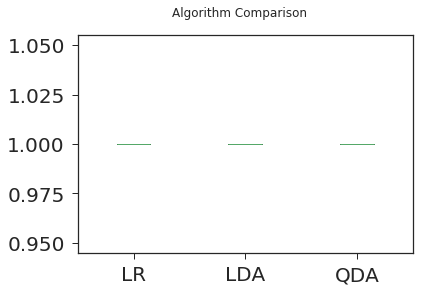

In [56]:

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('GNB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('SVMlin', SVC(kernel="linear", C=0.025)))
#models.append(('SVMpoly', SVC(kernel="poly")))
#models.append(('SVMg2', SVC(gamma=2, C=1)))
#models.append(('Neural', MLPClassifier()))
#models.append(('RFC', RandomForestClassifier()))
#models.append(('ADA', AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)))
#models.append(('ADA3', AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)))
#models.append(('EXT', ExtraTreesClassifier()))
#models.append(('RC', RidgeClassifier()))
#models.append(('RNeigh', RadiusNeighborsClassifier(200)))
#models.append(('ccCV', CalibratedClassifierCV()))
#models.append(('DTC', DecisionTreeClassifier()))
#models.append(('ETC', ExtraTreeClassifier()))



# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [57]:
# Make predictions on validation dataset
#ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={' tau':1, ' DIS':0.001}), n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)
ada = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)
#ada = ExtraTreesClassifier(class_weight={' tau':1000, ' DIS':1})
#ada = LogisticRegression(class_weight={' tau':10, ' DIS':1})
ada.fit(X_train, Y_train)
predictions = ada.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[  7   0]
 [  0 370]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         7
        1.0       1.00      1.00      1.00       370

avg / total       1.00      1.00      1.00       377

